In [1]:
import os
import geopandas as gpd
import pyproj

# Manually force the correct proj data path
os.environ["PROJ_LIB"] = "/home/kwameatt/anaconda3/envs/cs231n/share/proj"
pyproj.datadir.set_data_dir("/home/kwameatt/anaconda3/envs/cs231n/share/proj")
gdf = gpd.GeoDataFrame(
    {"LON": [10], "LAT": [50]},
    geometry=gpd.points_from_xy([10], [50]),
    crs="EPSG:4326"
)

print("Success! CRS is:", gdf.crs)

/home/kwameatt/anaconda3/envs/cs231n/lib/python3.7/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Success! CRS is: EPSG:4326


In [2]:
#hopefully this will fix the CRS import problem PERMANENTLY
%run pyproj_fix.py

In [3]:
from __future__ import division
import numpy as np
import pickle
import torch, random, copy
import torch.optim as optim
from torch import nn
from sh_utils import *
from basic_structure import IGNNK_ModOptionB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import pandas as pd
import re
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import geopandas as gpd
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt


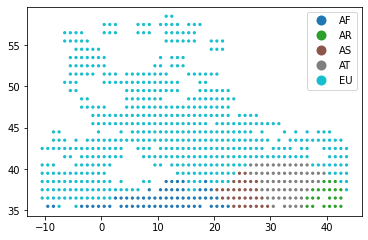

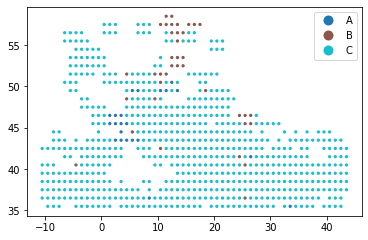

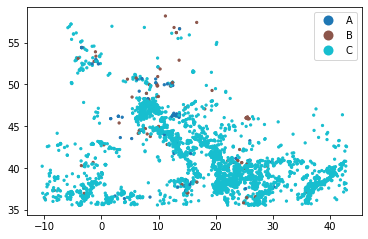

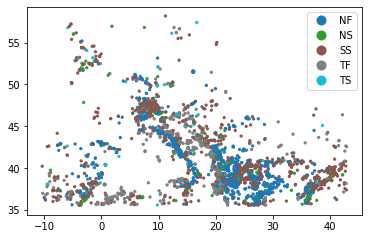

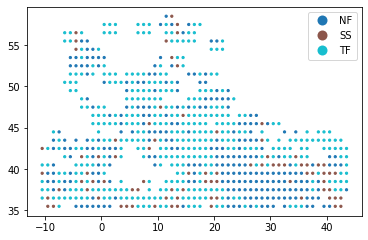

In [4]:
set_seed(42)

# Load training data = Anchor + grid nodes
grid_gdf_path = "/mnt/e/GNN_paper/2025_IGNNK/data/grids_train/all_grid_data_1p0r.csv"
anchor_data_path = "/mnt/e/GNN_paper/2025_IGNNK/data/anchors_train/WSM2025_EU.csv"

#generate, clean, and process data, then construct the graph adjacency and feature matrix 
kNN=8
th_bound = 17 #in degrees
p_boundary_bound_km = 90 #in kilometers
q_mode = "linear" # or inverse
sigma_km = 100.0
quality_frac= 0.10
q_r_km = 100


# sh_dat = generate_shmax_train_data(anchor_data_path,
#                               grid_gdf_path,
#                               kNN = kNN,
#                               sigma_km = 200.0,
#                               qual_R_km = 200,
#                               Q_cut_frac = 0.10,
#                               Q_mode="linear",
#                               theta_bound_deg=th_bound, #sharpness of abstract azimuth cluster boundary
#                               add_self_loops = True,
#                               scale_to_one= True)

sh_dat = generate_shmax_train_data(anchor_data_path,
                              grid_gdf_path,
                              kNN = kNN,
                              sigma_km = sigma_km,
                              qual_R_km = sigma_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              boundary_bound_km = p_boundary_bound_km,
                              cp_str = "hard",
                              add_self_loops = True,
                              scale_to_one = True)

A, X_target, grid_gdf, anchor_gdf, test_anchor_data, node_info = load_shmax_train_data()

df_cols = ['ID', 'LON', 'LAT', 'DEPTH', 'DIST', 'PLATE', 'QUALITY', 'REGIME', 'AZI', 'geometry']
grid_gdf = grid_gdf[df_cols] 
anchor_gdf = anchor_gdf[df_cols]
node_info = node_info[df_cols]
test_anchor_data = test_anchor_data[df_cols]

grid_gdf.plot(column='PLATE', markersize=5, legend=True)
grid_gdf.shape
grid_gdf.plot(column='QUALITY', markersize=5, legend=True)
anchor_gdf.plot(column='QUALITY', markersize=5, legend=True)
anchor_gdf.plot(column='REGIME', markersize=5, legend=True)
grid_gdf.plot(column='REGIME', markersize=5, legend=True)

In [12]:
# anchor_gdf = anchor_gdf[~(anchor_gdf["REGIME"] == 'U')]

In [5]:
max_dist  = node_info['DIST'].max()
dist_feat  = node_info['DIST'].fillna(0) / max_dist

categorical_cols = ['PLATE', 'QUALITY','REGIME']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(node_info[categorical_cols])

##
# Save encoder
with open("/mnt/e/GNN_paper/2025_IGNNK/data/num_array_files/ppb_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
###

cat_features = encoder.transform(node_info[categorical_cols].fillna('Unknown'))
# encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
# print("Encoded categories:", list(encoded_feature_names))

X_aux = np.column_stack([dist_feat, cat_features])
X_total = np.concatenate([X_target, X_aux], axis=-1)   # (N , h_total)

# print(f" Prepared input: {X_total.shape[0]} nodes x {X_total.shape[1]} features")
N, h_total = X_total.shape
h_target = X_target.shape[1] 
h_aux = h_total - h_target

#prepare mask
anchor_mask = (np.abs(X_total[:, 0]) + np.abs(X_total[:, 1])) > 1e-4
grid_mask = ~anchor_mask

#######
rng = np.random.default_rng(42)          # reproducible split
anchor_idx = np.where(anchor_mask)[0]
val_frac   = 0.15                       # 15 % hold-out
val_idx    = rng.choice(anchor_idx,
                        size=int(len(anchor_idx) * val_frac),
                        replace=False)
train_idx  = np.setdiff1d(anchor_idx, val_idx)

# training / validation node sets
know_set = set(train_idx)   # used for sub-graph sampling in training
val_set  = set(val_idx)     # used only for validation metric
#####
# anchor_idx = np.where(anchor_mask)[0]
grid_idx = np.where(grid_mask)[0]
unknow_set = set(grid_idx)
        ### Build pools
anchors = list(know_set)          # Va
grids   = list(unknow_set)        # Vg


############################3

##################3

In [14]:
anchor_mask.shape

(4725,)

In [15]:
grid_mask[grid_mask==True].shape

(701,)

In [16]:
grid_mask.shape

(4725,)

In [6]:
#Set Hyperparameters
n_o_n_m     = min(300, len(know_set)+len(unknow_set))
# n_m         = 60
ramp_epochs = 30
z           = 96
k           = 1
Max_episode = 150
learning_rate = 5e-4
batch_size  = 64
drop_p = 0.5 #dropout probability

E_maxvalue = 1.0   # cos/sin already [-1,1]
A_anchor = A[np.ix_(list(know_set), list(know_set))]

#Instantiate Model
STmodel = IGNNK_ModOptionB(h_total, h_target, z, k, dropout=drop_p)
criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # lower val error is better
    factor=0.5,        # halve LR on plateau
    patience=5,        # epochs to wait with no improvement
    threshold=1e-3,    # min change to count as improvement
    cooldown=2,        # epochs to wait after LR drop before resuming tracking
    min_lr=1e-6,       # don't go below this
    verbose=True       # prints LR reductions
)

# doing the following for file names to be used later
data_dir = '/mnt/e/GNN_paper/IGNNK/data/results_train/'
lr_str = f"{learning_rate:.0e}".replace("-", "m")
k_str = f"{k}".replace("-", "m")
k_nn = f"{kNN}".replace("-", "m")
b_cap = f"{int(p_boundary_bound_km)}".replace("-", "m")
# tags = f"ep{Max_episode}_bs{batch_size}_lr{lr_str}_z{z}_nm{n_m}"
tags = f"ep_{Max_episode}_bs{batch_size}_lr{lr_str}_z{z}_k_diff_{k_str}_kNN_{k_nn}_ramps_{ramp_epochs}_b_cap_{b_cap}"
# timestamp1 = datetime.now().strftime("%Y%m%d_%H%M%S")
file_prefix = f"{tags}"

In [7]:
len(know_set)

3421

In [9]:
import numpy as np
from sklearn.cluster import KMeans

def encode_axial_mean(c, s):
    C, S = np.sum(c), np.sum(s)
    n = np.hypot(C, S) + 1e-12
    return C/n, S/n

def km_xy(lon, lat):
    # simple local equirectangular to km around the mean latitude
    lat0 = np.radians(np.mean(lat))
    x = (np.radians(lon) * np.cos(lat0)) * 6371.0
    y =  np.radians(lat) * 6371.0
    return x, y

def build_anchor_prototypes(node_info, X_total, know_set, K=3, w_space=0.5):
    """
    Returns:
      centers_xy: (K,2) spatial centers (km)
      proto_cs  : (K,2) axial mean [cos2, sin2] per cluster
      labels    : (N_anchor,) cluster id for each anchor
    """
    idxA = np.array(sorted(list(know_set)))
    cA = X_total[idxA, 0]   # cos2θ
    sA = X_total[idxA, 1]   # sin2θ
    lonA = node_info['LON'].to_numpy()[idxA]
    latA = node_info['LAT'].to_numpy()[idxA]
    xA, yA = km_xy(lonA, latA)

    # feature scaling: balance space vs orientation (unit circle)
    # x,y scaled to ~[−1,1] range of the anchor cloud
    sx = max(np.std(xA), 1e-6); sy = max(np.std(yA), 1e-6)
    XA = np.column_stack([
        w_space * (xA / sx),
        w_space * (yA / sy),
        cA, sA
    ])

    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    labels = km.fit_predict(XA)

    centers_xy = np.zeros((K, 2), dtype=np.float32)
    proto_cs   = np.zeros((K, 2), dtype=np.float32)
    for k in range(K):
        mask = (labels == k)
        centers_xy[k, 0] = np.mean(xA[mask])
        centers_xy[k, 1] = np.mean(yA[mask])
        proto_cs[k] = encode_axial_mean(cA[mask], sA[mask])
    return centers_xy, proto_cs, labels


In [10]:
def axial_dtheta_deg(c1,s1,c2,s2):
    dot = np.clip(c1*c2 + s1*s2, -1.0, 1.0)
    return 0.5*np.degrees(np.arccos(dot))

def prototype_prior(node_info, proto_xy, proto_cs,
                    X_firstpass=None,          # (2,N) from a first pass; optional
                    sigma_km=80.0, sigma_theta_deg=None, topK=None):
    """
    Returns p: (2,N) prior field from K prototypes.
    If X_firstpass is None, uses spatial weights only.
    """
    lon = node_info['LON'].to_numpy()
    lat = node_info['LAT'].to_numpy()
    x, y = km_xy(lon, lat)
    N = len(lon); K = proto_xy.shape[0]
    # weights
    W = np.zeros((N, K), dtype=np.float32)
    for k in range(K):
        dx = x - proto_xy[k,0]; dy = y - proto_xy[k,1]
        dkm = np.hypot(dx, dy)
        w = np.exp(- (dkm / float(sigma_km))**2)
        if (X_firstpass is not None) and (sigma_theta_deg is not None):
            c_hat, s_hat = X_firstpass[0], X_firstpass[1]
            dth = axial_dtheta_deg(c_hat, s_hat, proto_cs[k,0], proto_cs[k,1])
            w *= np.exp(- (dth / float(sigma_theta_deg))**2)
        W[:, k] = w

    # (optional) keep only topK prototypes per node
    if topK is not None and topK < K:
        idx = np.argpartition(-W, kth=topK-1, axis=1)
        mask = np.zeros_like(W, dtype=bool)
        rows = np.arange(N)[:,None]
        mask[rows, idx[:, :topK]] = True
        W[~mask] = 0.0

    # normalized mixing
    Z = W.sum(axis=1, keepdims=True) + 1e-12
    Wn = W / Z
    C = (Wn @ proto_cs[:,0])
    S = (Wn @ proto_cs[:,1])
    # re-normalize onto unit circle
    norm = np.hypot(C, S) + 1e-12
    return np.vstack([C/norm, S/norm])   # (2,N)


In [11]:
set_seed(42)

# Split input into:
X_target_full = X_total[:, :2]  
X_aux_full    = X_total[:, 2:]  

# Prepare test set for evaluation
X_T = X_target_full.T

# Initialise metric logs
RMSE_list = []
MAE_list = []
R2_list = []
ang_mae_grid_list = []
loss_list = []
ang_mae_val_list =[]

best_state = None
best_mae = 1e9
best_val = 1e9
patience = ramp_epochs 
patience_counter = 0

rng = np.random.default_rng(123)
pseudo_grid_idx = rng.choice(anchors, size=max(1, int(0.2 * len(anchors))), replace=False).tolist()

#######$$$$$$$$$$$$$$$$$$$
# build once (anchors only)
proto_xy, proto_cs, _ = build_anchor_prototypes(node_info, X_total, know_set, K=3, w_space=0.5)

# # (optional) do a first pass to include orientation gating
# X_full_T = X_total.T.astype('float32')
# inp  = torch.from_numpy(X_full_T[np.newaxis])
# A_q  = torch.from_numpy(calculate_random_walk_matrix(A).T.astype('float32'))
# A_h  = torch.from_numpy(calculate_random_walk_matrix(A.T).T.astype('float32'))
# with torch.no_grad():
#     pred1 = STmodel(inp, A_q, A_h)[0].cpu().numpy()

# # prior from prototypes (use only spatial, or spatial×orient if you pass pred1 and sigma_theta_deg)
# P = prototype_prior(node_info, proto_xy, proto_cs,
#                     X_firstpass=pred1, sigma_km=80.0, sigma_theta_deg=20.0, topK=2)  # (2,N)

# # concat to your inputs before training/eval:
# # X_total: (N, h_total) with first 2 = target channels
# X_with_prior = np.concatenate([X_total, P.T], axis=1)  # adds 2 prior channels to X_aux


#######$$$$$$$$$$$$$$$$$$$


# Training Loop
for epoch in range(Max_episode):
    STmodel.train()
    n_m_epoch = current_mask_count(epoch,
                                   ramp_epochs=ramp_epochs,
                                   n_nodes=n_o_n_m,
                                   p0=0.20,  # start 20 %
                                   p1=0.50)  # end  50 %
    epoch_loss = 0.0
    for _ in range(batch_size):
        # know_mask = set(random.sample(know_set, n_o_n_m))
        nA_req = int(0.6 * n_o_n_m)
        nA = min(nA_req, len(anchors))
        nG = min(n_o_n_m - nA, len(grids))

        sub_A = random.sample(anchors, nA)
        sub_G = random.sample(grids,   nG)
        sub_idx = sub_A + sub_G  # anchors first, then grids
        nS = len(sub_idx)

        X_sub_target = X_target_full[sub_idx, :]  # (nS, 2)
        X_sub_aux    = X_aux_full[sub_idx, :]
        X_sub        = np.concatenate([X_sub_target, X_sub_aux], axis=1)

        # --- two masks ---
        m = min(n_m_epoch, nA)
        mask_anchor_locs = random.sample(range(nA), k=m) if m > 0 else []

        # input mask: zero targets for grids + masked anchors
        miss_mask_in = np.ones((nS, h_total), dtype=np.float32)
        if nG > 0:
            miss_mask_in[nA:, :h_target] = 0.0
        if m > 0:
            miss_mask_in[mask_anchor_locs, :h_target] = 0.0

        # loss mask: 1 only on masked anchors
        mask_loss = np.zeros((nS, h_target), dtype=np.float32)
        if m > 0:
            mask_loss[mask_anchor_locs, :] = 1.0

        # pack tensors
        Mf_inputs = torch.from_numpy((X_sub * miss_mask_in / E_maxvalue).T[np.newaxis].astype(np.float32))
        outputs_t = torch.from_numpy(X_sub[:, :h_target].T[np.newaxis].astype(np.float32))
        mask_t    = torch.from_numpy(mask_loss.T[np.newaxis].astype(np.float32))


        # Adjacency
        A_sub = A[np.ix_(sub_idx, sub_idx)]
        A_q = torch.from_numpy(calculate_random_walk_matrix(A_sub).T.astype(np.float32))
        A_h = torch.from_numpy(calculate_random_walk_matrix(A_sub.T).T.astype(np.float32))

        # Forward / Backward
        optimizer.zero_grad()
        X_pred = STmodel(Mf_inputs, A_q, A_h)
        #################$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$4
        # after you have X_pred (1,2,nS) and sub_idx
        lambda_prior = 1e-3
        P_full = prototype_prior(node_info, proto_xy, proto_cs, X_firstpass=None, sigma_km=sigma_km)  # (2,N)
        P_sub  = torch.from_numpy(P_full[:, sub_idx][np.newaxis].astype(np.float32))  # (1,2,nS)

        # encourage model to stay near prototype prior everywhere (or only on grids)
        is_grid = torch.zeros((1,1,len(sub_idx)), dtype=torch.float32)
        is_grid[:,:,len(sub_A):] = 1.0  # only grids if you want
        prior_loss = ((X_pred - P_sub)**2 * is_grid).mean()
        recon = criterion(X_pred * mask_t, outputs_t * mask_t) #this is the previously used reconstruction loss
        loss = recon + lambda_prior * prior_loss
        #################$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#         loss = criterion(X_pred * mask_t, outputs_t * mask_t)
        epoch_loss  += loss.item()
        loss.backward()
        optimizer.step()

    # Evaluation (val anchors + pseudo-grid) 
    STmodel.eval()
    with torch.no_grad():
        X_full_T = X_total.T.astype('float32')          # (h_total, N)
        inp  = torch.from_numpy(X_full_T[np.newaxis])
        A_q  = torch.from_numpy(calculate_random_walk_matrix(A).T.astype('float32'))
        A_h  = torch.from_numpy(calculate_random_walk_matrix(A.T).T.astype('float32'))
        pred = STmodel(inp, A_q, A_h)[0].cpu().numpy()  # (2, N)

    # validation angular-MAE (held-out anchors)
    val_idx = np.array(sorted(list(val_set)))
    ang_mae_val = angular_mae(pred[0, val_idx], pred[1, val_idx],
                          X_full_T[0, val_idx], X_full_T[1, val_idx])
    
    scheduler.step(ang_mae_val)

    # pseudo-grid angular-MAE (anchors hidden conceptually; we just score them here)
    pg_idx = np.array(pseudo_grid_idx)
    ang_mae_pgrid = angular_mae(pred[0, pg_idx], pred[1, pg_idx],
                            X_full_T[0, pg_idx], X_full_T[1, pg_idx])

    # early stopping on validation
    if ang_mae_val < best_val - 1e-6:
        best_val = ang_mae_val
        best_state = copy.deepcopy(STmodel.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping: no val-improvement (best val = {best_val:.2f}°)")
            break

    ang_mae_val_list.append(ang_mae_val)
    ang_mae_grid_list.append(ang_mae_pgrid)   # store pseudo-grid here
    loss_list.append(epoch_loss / batch_size)

    if epoch % 5 == 0:
        print(f"epoch {epoch:3d}"
              f" | train-loss {loss_list[-1]:.10f}"
              f" | ang-val-MAE {ang_mae_val:5.2f}°"
              f" | ang-pseudo-grid-MAE {ang_mae_pgrid:5.2f}°")
     
    # Save model
    torch.save(best_state, f"trained_models/iS_GNN_Trained_{file_prefix}.pth")

epoch   0 | train-loss 1.4500881219 | ang-val-MAE  9.36° | ang-pseudo-grid-MAE  9.19°
epoch   5 | train-loss 0.2018254206 | ang-val-MAE  8.81° | ang-pseudo-grid-MAE  8.92°
epoch  10 | train-loss 0.1568763743 | ang-val-MAE  8.24° | ang-pseudo-grid-MAE  8.44°
epoch  15 | train-loss 0.1630247599 | ang-val-MAE  8.12° | ang-pseudo-grid-MAE  8.34°
epoch  20 | train-loss 0.1789720606 | ang-val-MAE  6.81° | ang-pseudo-grid-MAE  7.06°
epoch  25 | train-loss 0.1996401534 | ang-val-MAE  6.63° | ang-pseudo-grid-MAE  6.77°
epoch  30 | train-loss 0.2183936376 | ang-val-MAE  6.98° | ang-pseudo-grid-MAE  7.48°
epoch  35 | train-loss 0.2181840099 | ang-val-MAE  7.40° | ang-pseudo-grid-MAE  7.84°
Epoch 00039: reducing learning rate of group 0 to 2.5000e-04.
epoch  40 | train-loss 0.2141652564 | ang-val-MAE  7.01° | ang-pseudo-grid-MAE  7.44°
epoch  45 | train-loss 0.2164533895 | ang-val-MAE  6.67° | ang-pseudo-grid-MAE  7.08°
Epoch 00051: reducing learning rate of group 0 to 1.2500e-04.
epoch  50 | trai

In [13]:
# pred.shape

(2, 4725)

In [17]:
# proto_xy, proto_cs, _ = build_anchor_prototypes(node_info, X_total, know_set, K=3, w_space=0.5)

In [19]:
## The post-blend where the confidence is low

# # after a full forward pred = (2,N)
# c, s = pred[0].copy(), pred[1].copy()
# mag = np.hypot(c, s); weak = mag < 0.15
# P = prototype_prior(node_info, proto_xy, proto_cs, X_firstpass=pred,
#                     sigma_km=80.0, sigma_theta_deg=20.0, topK=2)

# alpha = 0.5  # blend weight
# c[weak] = (1-alpha)*c[weak] + alpha*P[0, weak]
# s[weak] = (1-alpha)*s[weak] + alpha*P[1, weak]
# norm = np.hypot(c, s) + 1e-12
# c /= norm; s /= norm
# pred_blend = np.vstack([c, s])  # use for plotting


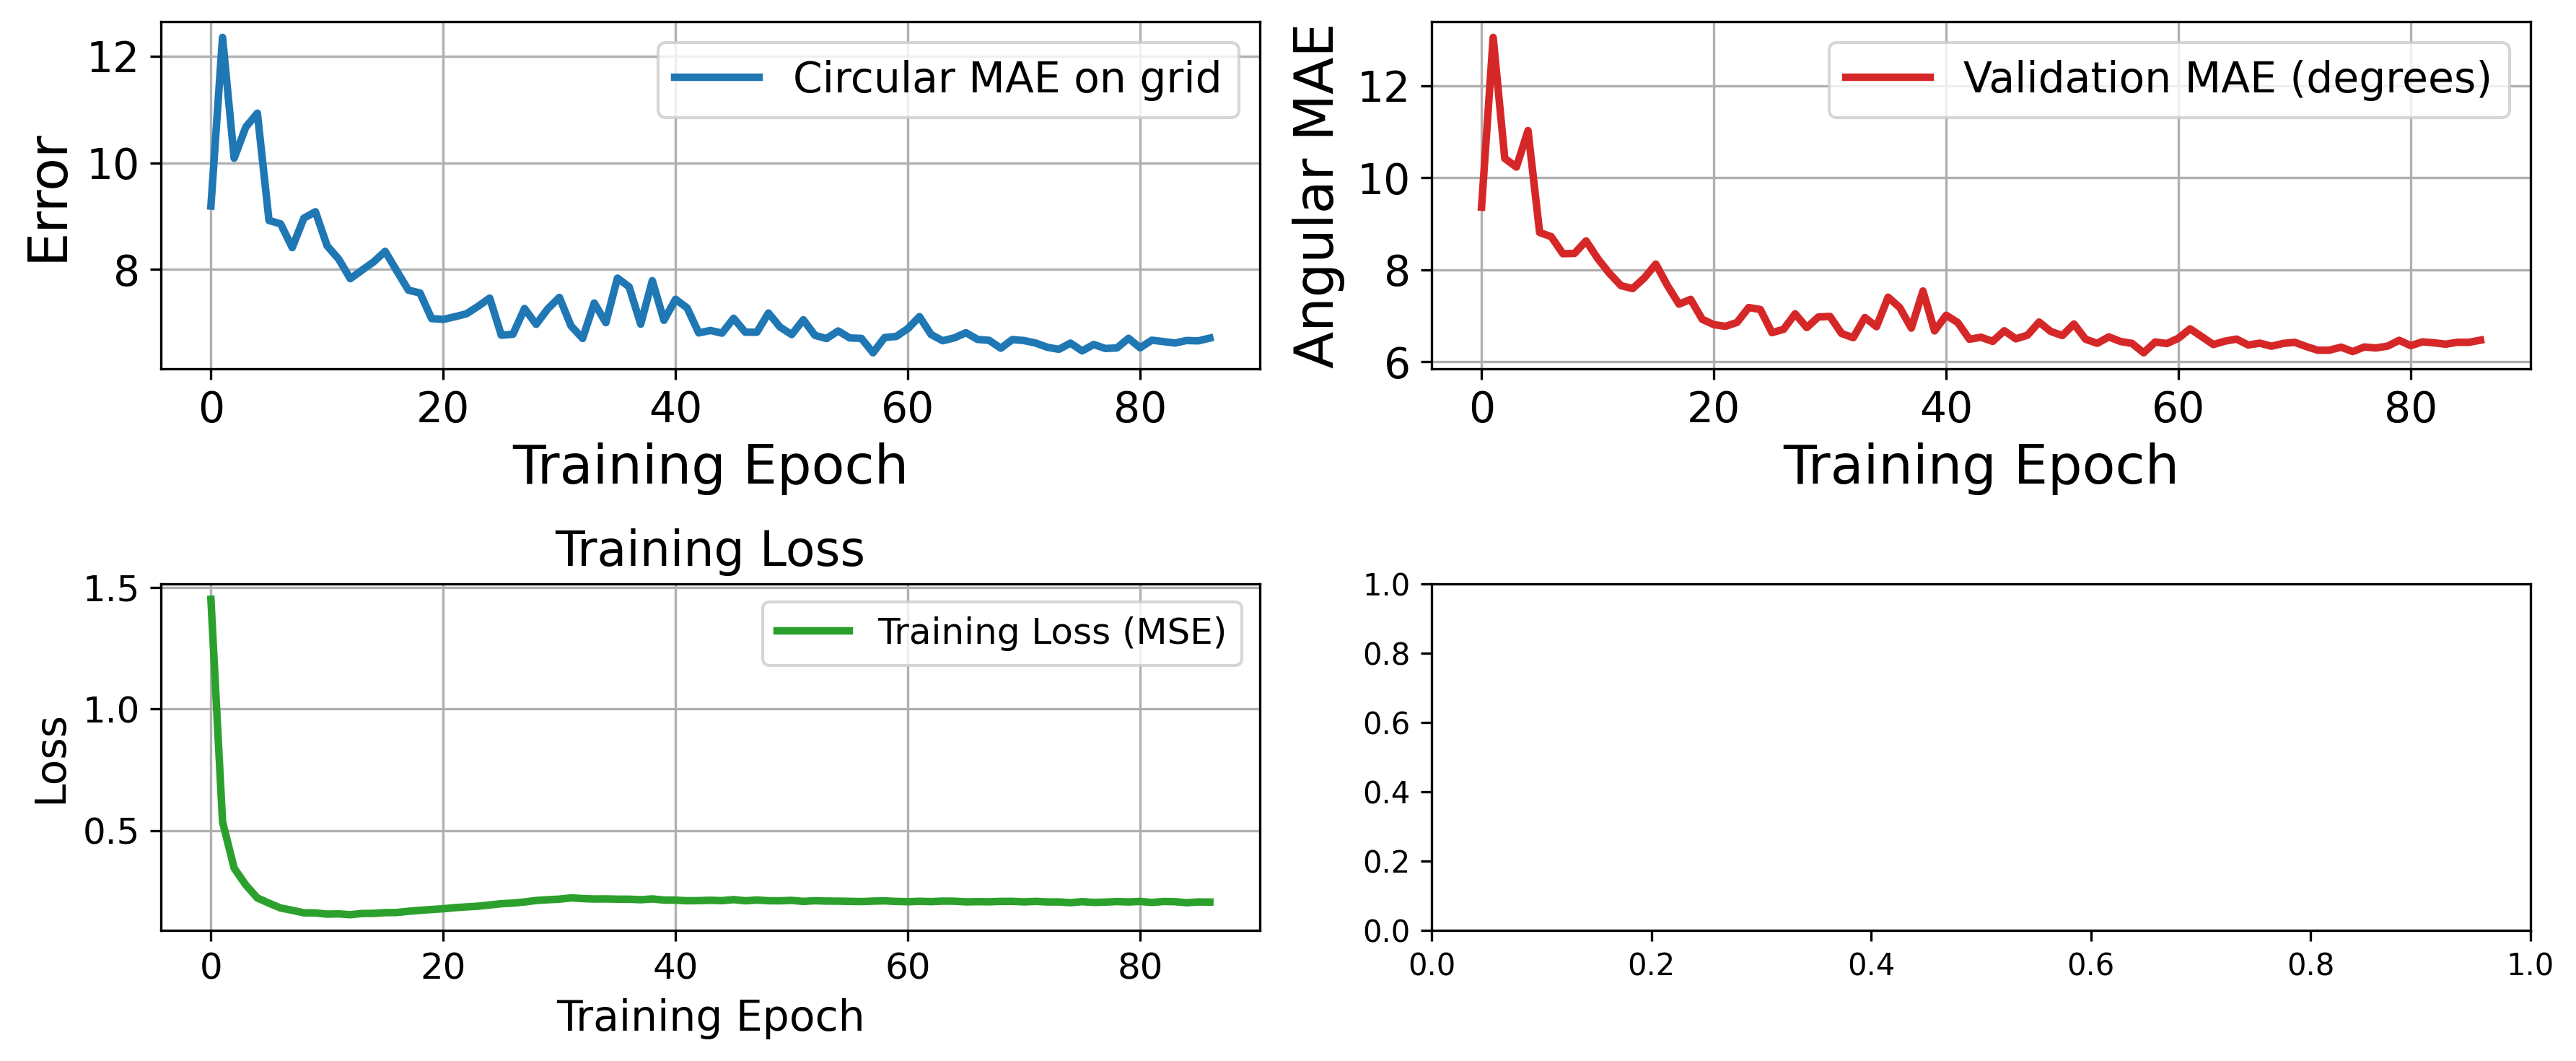

In [12]:
loss_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in loss_list]
MAE_grid_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in ang_mae_grid_list]
ang_mae_val_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in ang_mae_val_list]

metrics_df = pd.DataFrame({
    'Epoch': list(range(len(loss_list))),
    'Training_Loss': loss_list,
#     'RMSE': RMSE_list,
    'MAE': MAE_grid_list,
    'ang-VAL-MAE':ang_mae_val_list,
#     'R2': R2_list
})


fig0, ax0 = plt.subplots(2, 2, figsize=(12, 5), dpi=300)

# ax0[0, 0].plot(RMSE_list, label='RMSE on test graph', linewidth=2.5)
ax0[0, 0].plot(MAE_grid_list, label='Circular MAE on grid', linewidth=2.5)
ax0[0, 0].set_xlabel("Training Epoch", fontsize=18)
ax0[0, 0].set_ylabel("Error", fontsize=18)
ax0[0, 0].tick_params(axis="both", labelsize=14)
ax0[0, 0].legend(fontsize=14)
ax0[0, 0].grid(True)

ax0[0, 1].plot(ang_mae_val_list, label='Validation MAE (degrees)', linewidth=2.5, color='tab:red')
ax0[0, 1].set_xlabel("Training Epoch", fontsize=18)
ax0[0, 1].set_ylabel("Angular MAE", fontsize=18)
ax0[0, 1].tick_params(axis="both", labelsize=14)
ax0[0, 1].legend(fontsize=14)
ax0[0, 1].grid(True)

# # ax0[1, 0].plot(R2_list, label='R^2', linewidth=2.5, color='tab:red')
# ax0[1, 0].set_xlabel("Training Epoch", fontsize=18)
# ax0[1, 0].set_ylabel("Corr. Coeff.", fontsize=18)
# ax0[1, 0].tick_params(axis="both", labelsize=14)
# ax0[1, 0].legend(fontsize=14)
# ax0[1, 0].grid(True)

ax0[1, 0].plot(loss_list, label='Training Loss (MSE)', linewidth=2.5, color='tab:green')
ax0[1, 0].set_title("Training Loss", fontsize=16)
ax0[1, 0].set_xlabel("Training Epoch", fontsize=14)
ax0[1, 0].set_ylabel("Loss", fontsize=14)
ax0[1, 0].tick_params(axis="both", labelsize=12)
ax0[1, 0].legend(fontsize=12)
ax0[1, 0].grid(True)
fig0.tight_layout()

plot_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/figs/"
plot_file = f"training_error_curves_{tags}.png"
plot_path = os.path.join(plot_dir, plot_file)
fig0.savefig(plot_path, bbox_inches='tight', dpi=300)

# metrics_path = f"/mnt/e/GNN_paper/IGNNK/data/wsm2016/training_metrics_{file_prefix}.csv"
# metrics_df.to_csv(metrics_path, index=False)

# # print(f"Saved loss plot to: {loss_plot_path}")
# print(f"Saved metrics CSV to: {metrics_path}")

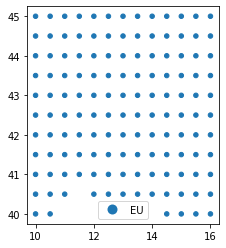

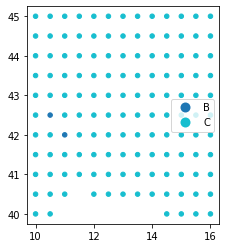

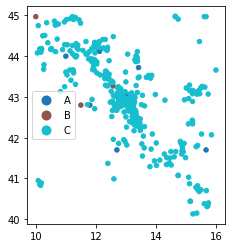

In [13]:
# anchor_data_path3 = "/mnt/e/GNN_paper/IGNNK/data/wsm2016/wsm2016_sicily.csv"
grid_gdf3 = "data/grids_train/all_grid_data_0p5r.csv"
sh_dat_3 = generate_shmax_train_data(anchor_data_path, grid_gdf3)
sh_dat_3 = generate_shmax_train_data(
                              anchor_data_path,
                              grid_gdf3,
                              kNN = kNN,
                              sigma_km = sigma_km,
                              qual_R_km = sigma_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              boundary_bound_km = p_boundary_bound_km,
                              cp_str = "hard",
                              add_self_loops = True,
                              scale_to_one = True
)

A3, X_target3, grid_gdf3, anchor_gdf3, _,node_info3 = load_shmax_train_data()

grid_gdf3 = grid_gdf3[df_cols]
node_info3 = node_info3[df_cols]
anchor_gdf3 = anchor_gdf3[df_cols]

grid_gdf3.plot(column='PLATE', markersize=20, legend=True)
grid_gdf3.plot(column='QUALITY', markersize=20, legend=True)
anchor_gdf3.plot(column='QUALITY', markersize=20, legend=True)
plt.show()

In [ ]:
## Post-blend 2 on the 0.5 grid resolution.
# after a full forward pred2 = (2,N)




In [17]:
# grid_gdf3.to_csv("data/grids_train/processed_grid_train_0p5r.csv", index=False)
# anchor_gdf3.to_csv("data/anchors_train/processed_anchor_train_0p5r.csv", index=False)

In [16]:
# node_info3[df_cols]

,ID,LON,LAT,DEPTH,DIST,PLATE,QUALITY,REGIME_1,AZI,geometry
86,wsm02413,13.42,43.72,0.0,542.000000,EU,A,SS,85.0,POINT (13.42000 43.72000)
110,wsm02482,12.57,43.27,10.0,477.000000,EU,B,NF,117.0,POINT (12.57000 43.27000)
290,wsm102226,12.99,43.61,24.4,521.000000,EU,C,SS,169.0,POINT (12.99000 43.61000)
308,wsm103605,14.74,44.91,26.0,684.000000,EU,C,SS,179.0,POINT (14.74000 44.91000)
385,wsm108318,11.29,44.01,12.0,549.000000,EU,C,NF,120.0,POINT (11.29000 44.01000)
...,...,...,...,...,...,...,...,...,...,...
4604,grid_000138,14.00,45.00,0.0,611.669217,EU,C,TF,NaN,POINT (14.00000 45.00000)
4605,grid_000139,14.50,45.00,0.0,611.670612,EU,C,TF,NaN,POINT (14.50000 45.00000)
4606,grid_000140,15.00,45.00,0.0,611.672007,EU,C,TF,NaN,POINT (15.00000 45.00000)
4607,grid_000141,15.50,45.00,0.0,611.673401,EU,C,SS,NaN,POINT (15.50000 45.00000)


In [25]:
# grid_gdf3.plot(column='QUALITY', markersize=20, legend=True)
# anchor_gdf3.plot(column='QUALITY', markersize=20, legend=True)

len(know_set)

3421

In [14]:
# max_depth3 = node_info3['DEPTH'].max()
max_dist3  = node_info3['DIST'].max()

# depth_feat3 = node_info3['DEPTH'].fillna(0) / max_depth3
dist_feat3  = node_info3['DIST'].fillna(0) / max_dist3

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features3 = encoder.transform(node_info3[["PLATE", 'QUALITY' ,"REGIME"]])

X_aux3 = np.column_stack([dist_feat3, cat_features3])  # shape (N , p)

X_total3 = np.concatenate([X_target3, X_aux3], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total3.shape[0]} nodes x {X_total3.shape[1]} features")


inp_3 = torch.from_numpy(X_total3.T.astype('float32')[np.newaxis])
A_q_3 = torch.from_numpy(calculate_random_walk_matrix(A3).T.astype('float32'))
A_h_3 = torch.from_numpy(calculate_random_walk_matrix(A3.T).T.astype('float32'))

with torch.no_grad():
    out3 = STmodel(inp_3, A_q_3, A_h_3)[0].cpu().numpy()   # shape (2 , N_test)

######################################
rng = np.random.default_rng(42)          # reproducible split

anchor_mask3 = (np.abs(X_total3[:, 0]) + np.abs(X_total3[:, 1])) > 1e-4
grid_mask3 = ~anchor_mask3
anchor_idx3 = np.where(anchor_mask3)[0]
grid_idx3 = np.where(grid_mask3)[0]
know_set3 = set(anchor_idx3)
unknow_set3 = set(grid_idx3)
##
proto3_xy, proto3_cs, _ = build_anchor_prototypes(node_info3, X_total3, know_set3, K=1, w_space=0.5)
c, s = out3[0].copy(), out3[1].copy()
mag = np.hypot(c, s); weak = mag < 0.15
P = prototype_prior(node_info3, proto3_xy, proto3_cs, X_firstpass=out3,
                    sigma_km=sigma_km, sigma_theta_deg=th_bound, topK=2)
alpha = 0.5  # blend weight
c[weak] = (1-alpha)*c[weak] + alpha*P[0, weak]
s[weak] = (1-alpha)*s[weak] + alpha*P[1, weak]
norm = np.hypot(c, s) + 1e-12
c /= norm; s /= norm
pred_blend = np.vstack([c, s])  # use for plotting
#######################################

pred_cos3 = pred_blend[0]
pred_sin3 = pred_blend[1]
true_cos3 = X_target3[:, 0]
true_sin3 = X_target3[:, 1]

azi_pred3 = decode_azimuth(pred_cos3, pred_sin3)
azi_true3 = decode_azimuth(true_cos3, true_sin3)
azi_err3  = np.minimum(np.abs(azi_pred3 - azi_true3), 180 - np.abs(azi_pred3 - azi_true3))
mae_deg3  = azi_err3.mean()

print(f"Angular MAE at 0.5 degree resolution: {mae_deg3:.2f}")

 Prepared input: 653 nodes x 16 features
Angular MAE at 0.5 degree resolution: 11.91


In [15]:
df_test3 = node_info3.copy()
df_test3['AZI'] = azi_true3
df_test3['AZI_PRED'] = azi_pred3
df_test3['AZI_ERROR'] = azi_err3
df_test3 = df_test3[['ID', 'LON','LAT','geometry','PLATE', 'REGIME' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
fname0 = f"iS-GNN_grid_0p5r_results_{tags}.csv"
fname1 = f"iS-GNN_anchor_0p5r_results_{tags}.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
df_test3[df_test3["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test3[df_test3["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [30]:
len(know_set3)
len(unknow_set3)

135

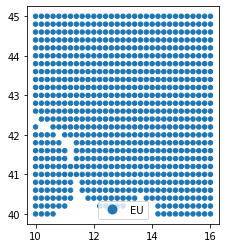

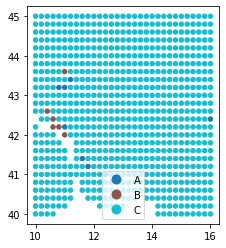

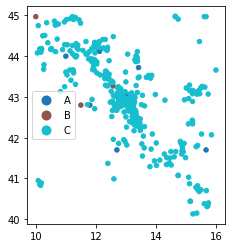

In [15]:
grid_gdf4 = "data/grids_train/all_grid_data_0p2r.csv"
# sh_dat_4 = generate_shmax_train_data(anchor_data_path,
#                               grid_gdf4,
#                               kNN = kNN,
#                               sigma_km = 200.0,
#                               qual_R_km = 200,
#                               Q_cut_frac = 0.10,
#                               theta_bound_deg=th_bound+10, #sharpness of abstract azimuth cluster boundary
#                               add_self_loops = True,
#                               scale_to_one= True)
sh_dat_4 = generate_shmax_train_data(
                              anchor_data_path,
                              grid_gdf4,
                              kNN = kNN,
                              sigma_km = sigma_km,
                              qual_R_km = q_r_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              boundary_bound_km = p_boundary_bound_km,
                              cp_str = "hard",
                              add_self_loops = True,
                              scale_to_one = True
)

A4, X_target4, grid_gdf4, anchor_gdf4, _,node_info4 = load_shmax_train_data()

grid_gdf4 = grid_gdf4[df_cols]
node_info4 = node_info4[df_cols]
anchor_gdf4 = anchor_gdf4[df_cols]

grid_gdf4.plot(column='PLATE', markersize=20, legend=True)
grid_gdf4.plot(column='QUALITY', markersize=20, legend=True)
anchor_gdf4.plot(column='QUALITY', markersize=20, legend=True)
plt.show()

In [21]:
# node_info3['PLATE'].values

In [13]:
# max_depth3 = node_info3['DEPTH'].max()
max_dist4  = node_info4['DIST'].max()

# depth_feat3 = node_info3['DEPTH'].fillna(0) / max_depth3
dist_feat4  = node_info4['DIST'].fillna(0) / max_dist4

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)

cat_features4 = encoder.transform(node_info4[["PLATE", 'QUALITY' ,"REGIME"]])

X_aux4 = np.column_stack([dist_feat4, cat_features4])  # shape (N , p)

X_total4 = np.concatenate([X_target4, X_aux4], axis=-1)   # (N , h_total)

print(f" Prepared input: {X_total4.shape[0]} nodes x {X_total4.shape[1]} features")


inp_4 = torch.from_numpy(X_total4.T.astype('float32')[np.newaxis])
A_q_4 = torch.from_numpy(calculate_random_walk_matrix(A4).T.astype('float32'))
A_h_4 = torch.from_numpy(calculate_random_walk_matrix(A4.T).T.astype('float32'))

with torch.no_grad():
    out4 = STmodel(inp_4, A_q_4, A_h_4)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos4 = out4[0]
pred_sin4 = out4[1]
true_cos4 = X_target4[:, 0]
true_sin4 = X_target4[:, 1]

azi_pred4 = decode_azimuth(pred_cos4, pred_sin4)
azi_true4 = decode_azimuth(true_cos4, true_sin4)
azi_err4  = np.minimum(np.abs(azi_pred4 - azi_true4), 180 - np.abs(azi_pred4 - azi_true4))
mae_deg4  = azi_err4.mean()

print(f"Angular MAE at 0.2 degree resolution: {mae_deg4:.2f}")

 Prepared input: 1284 nodes x 16 features
Angular MAE at 0.2 degree resolution: 21.44


In [150]:
# df_test6[df_test6['AZI']==0].to_csv('/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/POSTER-AI-DAY/NEW_GRID_GNN_INTERPOLATIONS.csv', index=False)

In [38]:
df_test4 = node_info4.copy()
df_test4['AZI'] = azi_true4
df_test4['AZI_PRED'] = azi_pred4
df_test4['AZI_ERROR'] = azi_err4
df_test4 = df_test4[['ID', 'LON','LAT','geometry','PLATE', 'REGIME' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# results_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
fname0 = f"iS-GNN_grid_0p2r_results_{tags}.csv"
fname1 = f"iS-GNN_anchor_0p2r_results_{tags}.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
df_test4[df_test4["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test4[df_test4["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)